# "SpreadSheet Munging Strategies in Python - Pivot Tables - Simple Unpivoting"
> "Extract data from pivot tables in a spreadsheet"

- toc: true
- branch: master
- badges: true
- hide_binder_badge: True
- hide_colab_badge: True
- comments: true
- categories: [Spreadsheet, Python, Pandas]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# __Pivot Tables - Simple Unpivoting__

This is part of a series of blog posts about extracting data from spreadsheets using Python.  It is based on the [book](https://nacnudus.github.io/spreadsheet-munging-strategies/index.html) written by [Duncan Garmonsway](https://twitter.com/nacnudus?lang=en), which was written primarily for R users. LInks to the other posts are on the [homepage](https://samukweku.github.io/data-wrangling-blog/).

Pivot tables offer a summarized version of the data, and are usually succinct and visually appealing. However, for analysis, it is not so good. How do we convert pivot tables to tidy data? This section covers that. We'll see various kinds of pivot tables, and work through each of them.

In [1]:
import pandas as pd
import numpy as np

In [2]:
filename = "worked-examples.xlsx"

### __Case 1: Multiple Row and Column headers__
![pivot-annotations.png](Images/pivot-annotations.png)
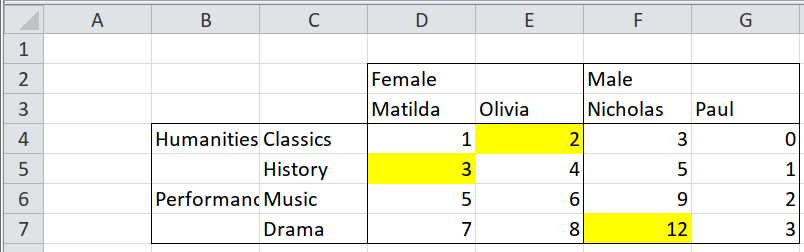

![pivot-annotations-headerrowandcolumn.png](Images/formattedrowsandcolumns.jpg)

**Observations**:
1. There are two header rows - gender and names.
2. There are also two header columns on the left - Fields(Humanities, Performance) and Subjects(Classics, History, ...)
3. For this case we wont be concerned with the colour formats. We'll look at that in a later section.

In [3]:
sheet = 'pivot-annotations'

df = (pd.read_excel(filename, 
                    sheet_name = sheet,
                    header = None
                   )
      #get rid of completely null columns and rows
      .dropna(how='all')
      .dropna(how='all',axis=1)
      #fill sideways on the gender
      .ffill(axis=1)
      #fill downwards on the fields column
      .ffill()
      #set index to the first two columns - the header columns
      .set_index([1,2])
     )

df

3       4         5     6
1           2                                        
NaN         NaN        Female  Female      Male  Male
            NaN       Matilda  Olivia  Nicholas  Paul
Humanities  Classics        1       2         3     0
            History         3       4         5     1
Performance Music           5       6         9     2
            Drama           7       8        12     3

In [4]:
#set the columns to the first two rows - the header rows
df.columns = pd.MultiIndex.from_arrays(df.iloc[:2].to_numpy())
df.columns = df.columns.set_names(['gender','student'])

#final cleanup to tidy form

       #get rid of the first two rows
       #they are already headers,
       #so not needed within the dataframe
res = (df.iloc[2:] 
       .rename_axis(index=['field', 'subject'])
       .stack(['gender', 'student'])
       .reset_index(name='scores')
      )

res

,field,subject,gender,student,scores
0,Humanities,Classics,Female,Matilda,1
1,Humanities,Classics,Female,Olivia,2
2,Humanities,Classics,Male,Nicholas,3
3,Humanities,Classics,Male,Paul,0
4,Humanities,History,Female,Matilda,3
5,Humanities,History,Female,Olivia,4
6,Humanities,History,Male,Nicholas,5
7,Humanities,History,Male,Paul,1
8,Performance,Music,Female,Matilda,5
9,Performance,Music,Female,Olivia,6


### __Case 2 : Multiple rows or columns of headers, with meaningful formatting__
![pivot-annotations.png](Images/pivot-annotations.png)

Same as above, except we have to capture the format details. To get these details, we'll make use of another library - [Openpyxl](https://openpyxl.readthedocs.io/en/stable/index.html)

In [5]:
# read in file and sheet
from openpyxl import load_workbook
from collections import defaultdict
wb = load_workbook(filename)
ws = wb["pivot-annotations"]

d = defaultdict(list)
#Iterate through each row in the sheet and get the details
for row in ws.iter_rows(min_row=1,
                        max_row=ws.max_row,
                        min_col=1,
                        max_col=ws.max_column):

    for cell in row:
        #if the data type is number format, lump the cell value with the cell color
        #this is because only the cells with numbers are formatted
        if cell.data_type == "n" and cell.value is not None:
            data = ','.join((str(cell.value), cell.fill.fgColor.rgb))
        else:
            data = cell.value
        d[cell.row].append(data)

In [6]:
#view the dataframe
df = pd.DataFrame(d)   

df

,1,2,3,4,5,6,7
0,None,None,None,None,None,None,None
1,None,None,None,Humanities,None,Performance,None
2,None,None,None,Classics,History,Music,Drama
3,None,Female,Matilda,"1,00000000","3,FFFFFF00","5,00000000","7,00000000"
4,None,None,Olivia,"2,FFFFFF00","4,00000000","6,00000000","8,00000000"
5,None,Male,Nicholas,"3,00000000","5,00000000","9,00000000","12,FFFFFF00"
6,None,None,Paul,"0,00000000","1,00000000","2,00000000","3,00000000"


Our data is quite similar to the data in case 1, except for the fact that the scores have colour values. Let's proceed to clean up the data into a tidy form: 

In [7]:
df = (df
      #remove complete nulls, column and row wise
      .dropna(how='all')
      .dropna(how='all',axis=1)
      .ffill(axis=1)
      .ffill()
      #set the first two rows as the header columns
      .set_index([2,3])
     )

In [8]:
df

4           5            6            7
2      3                                                         
NaN    NaN       Humanities  Humanities  Performance  Performance
       NaN         Classics     History        Music        Drama
Female Matilda   1,00000000  3,FFFFFF00   5,00000000   7,00000000
       Olivia    2,FFFFFF00  4,00000000   6,00000000   8,00000000
Male   Nicholas  3,00000000  5,00000000   9,00000000  12,FFFFFF00
       Paul      0,00000000  1,00000000   2,00000000   3,00000000

In [9]:
#more cleanup

#set the first two rows as the header row
df.columns = pd.MultiIndex.from_arrays(df.iloc[:2].to_numpy())
df.columns = df.columns.set_names(['field','subject'])

#final cleanup to tidy form

res = (df.iloc[2:] 
       .rename_axis(index=['gender', 'student'])
       .stack(['field', 'subject'])
       .str.split(',',expand=True) #breaks it into separate columns - scores and colours
       .set_axis(['scores','fill_colour'],axis=1) #replace column names
       .astype({'scores':'int8'})
      )

res

scores fill_colour
gender student  field       subject                     
Female Matilda  Humanities  Classics       1    00000000
                            History        3    FFFFFF00
                Performance Drama          7    00000000
                            Music          5    00000000
       Olivia   Humanities  Classics       2    FFFFFF00
                            History        4    00000000
                Performance Drama          8    00000000
                            Music          6    00000000
Male   Nicholas Humanities  Classics       3    00000000
                            History        5    00000000
                Performance Drama         12    FFFFFF00
                            Music          9    00000000
       Paul     Humanities  Classics       0    00000000
                            History        1    00000000
                Performance Drama          3    00000000
                            Music          2    00000000

### __Case 3 : Mixed headers and notes in the same row/column, distinguished by formatting__
![pivot-notes.png](Images/pivot-notes.png)
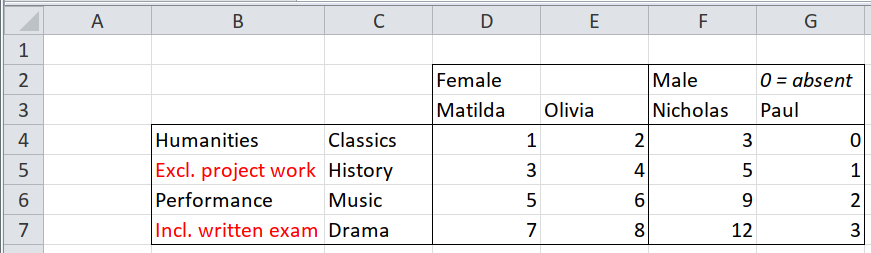

In this case, the <font color='red'>highlighted texts</font> should be excluded, as they are just notes and not relevant. Same goes for the 0=absent in G2 cell, which is *italicized*.

In [10]:
sheet = "pivot-notes"
wb = load_workbook(filename)
ws = wb[sheet]

d = defaultdict(list)

for row in ws.iter_rows(min_row=1,
                        max_row=ws.max_row,
                        min_col=1,
                        max_col=ws.max_column):

    for cell in row:
         # this excludes any cell that has a red font or is italicized 
        if cell.font.color.rgb == "FFFF0000" or cell.font.i:
            cell.value = None
        d[cell.row].append(cell.value)      

In [11]:
df = pd.DataFrame(d)
df

,1,2,3,4,5,6,7
0,None,None,None,None,None,None,None
1,None,None,None,Humanities,None,Performance,None
2,None,None,None,Classics,History,Music,Drama
3,None,Female,Matilda,1,3,5,7
4,None,None,Olivia,2,4,6,8
5,None,Male,Nicholas,3,5,9,12
6,None,None,Paul,0,1,2,3


Our data looks like case 2. Let's run through it and clean up

In [12]:
df = (df
      .dropna(how='all')
      .dropna(how='all',axis=1)
      .ffill(axis=1)
      .ffill()
      .set_index([2,3])
     )


#create multiIndex columns
df.columns = pd.MultiIndex.from_arrays(df.iloc[:2].to_numpy())
df.columns = df.columns.set_names(['field','subject'])

#final cleanup to tidy form

res = (df.iloc[2:] 
       .rename_axis(index=['gender', 'student'])
       .stack(['field', 'subject'])
       .reset_index(name='scores')
      )

res

,gender,student,field,subject,scores
0,Female,Matilda,Humanities,Classics,1
1,Female,Matilda,Humanities,History,3
2,Female,Matilda,Performance,Drama,7
3,Female,Matilda,Performance,Music,5
4,Female,Olivia,Humanities,Classics,2
5,Female,Olivia,Humanities,History,4
6,Female,Olivia,Performance,Drama,8
7,Female,Olivia,Performance,Music,6
8,Male,Nicholas,Humanities,Classics,3
9,Male,Nicholas,Humanities,History,5


### __Case 4: Mixed levels of headers in the same row/column, distinguished by formatting__
![pivot-hierarchy.png](Images/pivot-hierarchy.png)
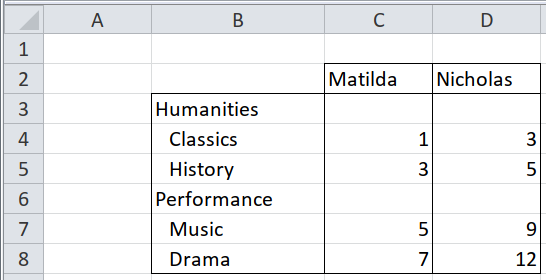

The formatting here refers to the indent - notice how Humanities and Performance are closer to the border compared to the subjects. Same goes for Matilda and Nicholas. Getting the indent information would require the use of Openpyxl. This data can however be handled easily by Pandas - for the header columns, we can use the adjacent null cells as identifiers:

In [13]:
df = (pd.read_excel(filename,
                    sheet_name="pivot-hierarchy",
                    header=None
                   )
      .dropna(how='all')
      .dropna(how='all',axis=1)
      #extract the field column
      .assign(field = lambda x: np.where(x[2].isna(),x[1],np.nan))
      .assign(field = lambda x: x['field'].ffill())
      .dropna(subset=[2])
      #replacement of null values for specific columns
      .fillna({1:'subject', 'field':'field'})
     )

#get the student names as part of the columns
df.columns = df.iloc[0]

#cleanup some more
res = (df
       .iloc[1:] #first row not needed anymore
       #rearrange the dataframe by
       #getting the students as part of the data
       #essentially moving from wide to long format
       .melt(id_vars=['field', 'subject'],
             var_name = 'student',
             value_name='scores'
            )
       .sort_values(['field','scores'], ignore_index = True)
      )

res

,field,subject,student,scores
0,Humanities,Classics,Matilda,1
1,Humanities,History,Matilda,3
2,Humanities,Classics,Nicholas,3
3,Humanities,History,Nicholas,5
4,Performance,Music,Matilda,5
5,Performance,Drama,Matilda,7
6,Performance,Music,Nicholas,9
7,Performance,Drama,Nicholas,12
